# Standard scanpy workflow version 2.8 #

Pancreatic cancer data available at PRJCA001063. 

### Import section ###

In [1]:
import besca as bc
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
from scipy import sparse, io
import os
import time
sc.logging.print_versions()

import logging
import seaborn as sns

# for standard processing, set verbosity to minimum
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)
version = '2.8'
start0 = time.time()

./.local/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,
./.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


scanpy==1.5.1 anndata==0.7.3 umap==0.3.10 numpy==1.17.4 scipy==1.5.1 pandas==1.0.3 scikit-learn==0.21.3 statsmodels==0.10.2 python-igraph==0.8.2 leidenalg==0.8.0


## Setup Standard Wokflow

### Parameters to be set - on the command line or here ###

In [2]:
# decisions to be made
species = 'human'
batch_to_correct = 'None' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
analysis_name = 'StdWf1_PRJCA001063_CRC_besca2'
split_condition='Patient' #'experiment' is generally a good default
dynrange=['B2m','Actb','Pgk1','Ctcf'] #genes for which to plot dynamic range
if species=='human': dynrange=[x.upper() for x in dynrange]

#additional labeling
labeling_to_use = 'Cell_type' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
labeling_name = 'Cell_type' # define name under which the labeling should be exported
labeling_description = 'celltype annotation' #define description which should be saved to labeling_info file
labeling_author = 'public' #define author which should be saved to labeling info file

### Define Input ###

In [3]:
# define filepath (this is the folder that contains "raw" and "analyzed")
root_path = os.getcwd() #

### Standard parameters - these should be kept as stable as possible ###

In [4]:
# the standard parameter section
standard_min_genes = 500
standard_min_cells = 20
standard_min_counts = 1000
standard_n_genes = 8000 # this is the most tricky one to set
standard_percent_mito = 0.1
standard_max_counts = 80000 #might be redundant with n_genes

## Standard Pipeline
(note nothing below this point should be modified!!)

In [5]:
#define standardized filepaths based on above input
results_folder = os.path.join(root_path, 'analyzed', analysis_name)
results_file = os.path.join(results_folder, analysis_name + '.h5ad') # specify a .h5ad file for storing the results
log_file = os.path.join(results_folder, analysis_name + '.standard.log') # specify a log file for keeping a short summary and overview
sc.settings.figdir = os.path.join(results_folder, 'figures')

#setup standard workflow (generates output directories and setsup logging file)
bc.st.setup(results_folder, 
          analysis_name, 
          labeling_name, 
          labeling_to_use, 
          log_file, 
          version,
          root_path, 
          species, 
          batch_to_correct, 
          standard_min_genes,
          standard_min_cells,
          standard_min_counts,
          standard_n_genes,
          standard_percent_mito,
          standard_max_counts)

#read input data
adata = bc.st.read_matrix(root_path)
#adata = bc.datasets.pbmc_storage_raw()#(root_path)

LOG MESSAGE: Standard Pipeline Version 2.8 used
LOG MESSAGE: 2020-07-08
LOG MESSAGE: Analysis 'StdWf1_PRJCA001063_CRC_besca2' on data located in'.'
LOG MESSAGE: species: human
LOG MESSAGE: Batch effect to correct: None
LOG MESSAGE: Parameters:
LOG MESSAGE: 	standard_min_genes = 500
LOG MESSAGE: 	standard_min_cells = 20
LOG MESSAGE: 	standard_min_counts = 1000
LOG MESSAGE: 	standard_n_genes = 8000
LOG MESSAGE: 	standard_max_counts = 80000
LOG MESSAGE: 	standard_percent_mito = 0.1
LOG MESSAGE: 	Time for creating all output directories and setting up logging: 0.018s


all output directories created successfully
reading matrix.mtx
adding cell barcodes
adding genes
making var_names unique
adding ENSEMBL gene ids to adata.var
adding annotation


LOG MESSAGE: After input: 57530 cells, 18008 genes
LOG MESSAGE: 	Time for reading data: 6.511s


In [6]:
adata.write(results_file+'.raw.h5ad')

... storing 'CONDITION' as categorical
... storing 'Patient' as categorical
... storing 'Type' as categorical
... storing 'Cell_type' as categorical
... storing 'SYMBOL' as categorical


In [26]:
#calculate mitochondrial gene content
bc.pp.fraction_counts(adata=adata) #

None of the genes from input list found in data set. Please ensure you have correctly specified use_genes to match the type of genes saved in adata.var_names.


In [27]:
# Save the raw data
adata.write(results_file+'.raw.h5ad')

... storing 'CONDITION' as categorical
... storing 'Patient' as categorical
... storing 'Type' as categorical
... storing 'Cell_type' as categorical
... storing 'SYMBOL' as categorical


### Visualization of quality control plots and selected filtering parameters

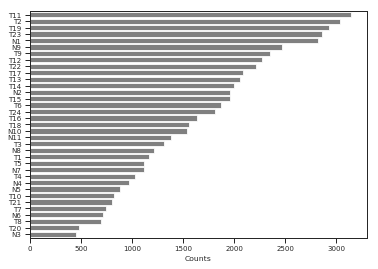

In [29]:
### have a look at cell nrs per sample ### 
sns.set_context("paper", font_scale=0.8)
temp=bc.tl.count_occurance(adata,split_condition)
sns.barplot(y=temp.index,x=temp.Counts,color='gray',orient='h')

##### Transcript Capture Efficiency
This plot gives you an idea about the sequencing depth and if the sequencing has reached saturation or not.

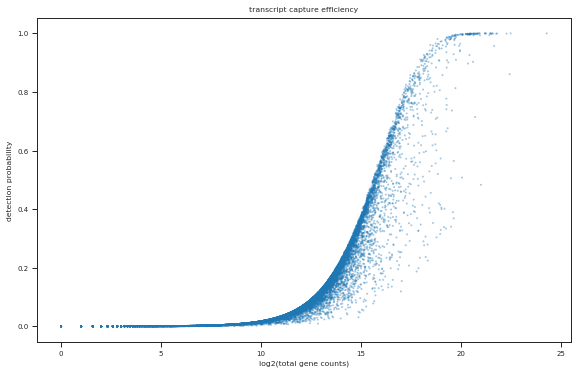

In [30]:
fig, ax = plt.subplots(1)
fig.set_figwidth(8)
fig.set_figheight(5)
fig.tight_layout()

bc.pl.transcript_capture_efficiency(adata,ax=ax)
fig.savefig(os.path.join(results_folder, 'figures/transcriptcaptureefficiency.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

##### Library Size distribution
This plot gives you an idea about the library size distribution in your dataset before processing.

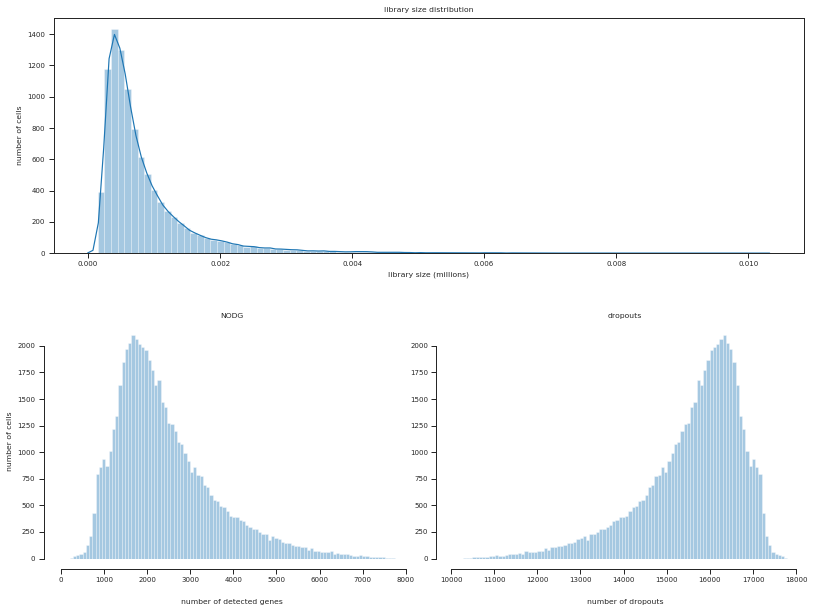

In [31]:
fig = bc.pl.librarysize_overview(adata, bins=100)
fig.savefig(os.path.join(results_folder, 'figures/librarysize.png'), format='png',bbbox_inches = 'tight') #save figure for QC report

In [32]:
adata_unfiltered = adata.copy()

##### Selected Filtering Parameters

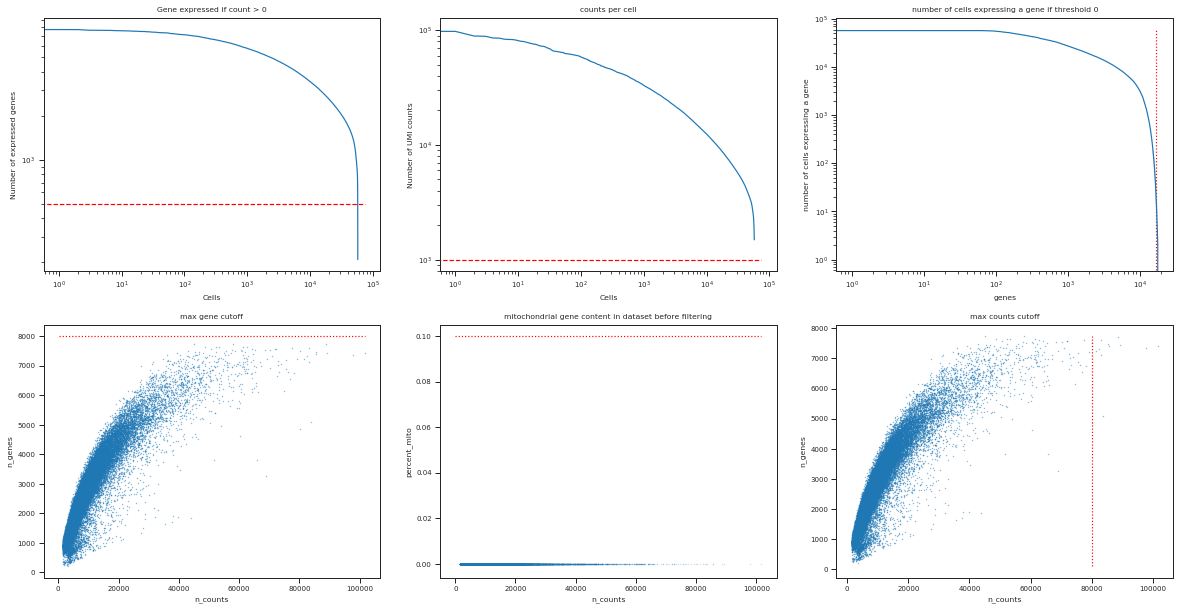

In [33]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows=2)
fig.set_figwidth(17)
fig.set_figheight(9)
fig.tight_layout(pad=4.5)

bc.pl.kp_genes(adata, min_genes=standard_min_genes, ax = ax1)
bc.pl.kp_counts(adata, min_counts=standard_min_counts, ax = ax2)
bc.pl.kp_cells(adata, min_cells=standard_min_cells, ax = ax3)
bc.pl.max_genes(adata, max_genes=standard_n_genes, ax = ax4)
bc.pl.max_mito(adata, max_mito=standard_percent_mito, annotation_type='SYMBOL', species=species, ax = ax5)
bc.pl.max_counts(adata, max_counts=standard_max_counts, ax=ax6)
fig.savefig(os.path.join(results_folder, 'figures/filtering_thresholds.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

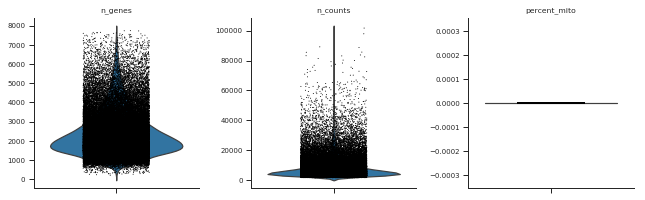

In [34]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.2, multi_panel=True, save = '.before_filtering.png')

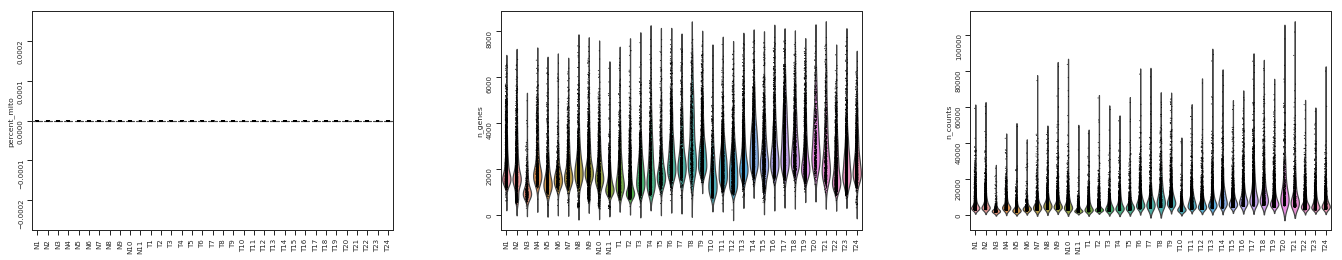

In [35]:
### check mitochondrial reads per sample 
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.before_filtering.split.png')

### First filtering on gene and cell counts

In [36]:
%%capture filtering1
adata = bc.st.filtering_cells_genes_min(adata, standard_min_cells, standard_min_genes, standard_min_counts)

LOG MESSAGE: After filtering for minimum number of cells and minimum number of expressed genes: 57436 cells, 17004 genes
LOG MESSAGE: After filtering for minimum number of cells and minimum number of expressed genes: 57436 cells, 17004 genes
LOG MESSAGE: 	Time for filtering: 10.047s
LOG MESSAGE: 	Time for filtering: 10.047s


In [37]:
filtering1.show()

started with  57530  total cells and  18008  total genes
removed 94 cells that did not express at least 500  genes
removed 0 cells that did not have at least 1000 counts
removed 1004 genes that were not expressed in at least 20 cells
finished with 57436  total cells and 17004 total genes


### Second filtering on mitochondrial genes, and upper limit for gene number ###

In [38]:
%%capture filtering2
adata = bc.st.filtering_mito_genes_max(adata, standard_percent_mito, standard_n_genes, standard_max_counts)

LOG MESSAGE: After filtering for maximum number of expressed genes and max percent mito: 57423 cells, 17004 genes
LOG MESSAGE: After filtering for maximum number of expressed genes and max percent mito: 57423 cells, 17004 genes
LOG MESSAGE: 	Time for filtering: 7.668s
LOG MESSAGE: 	Time for filtering: 7.668s


In [39]:
filtering2.show()

started with  57436  total cells and  17004  total genes
removed 0 cells that expressed more than 8000 genes
removed 13 cells that had more than 80000  counts
removed  0  cells that expressed  10.0 percent mitochondrial genes or more
finished with 57423  total cells and 17004 total genes


###  Filtered dataset characteristics

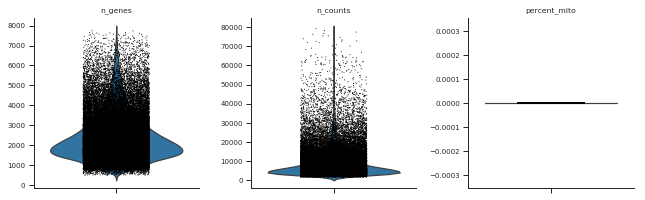

In [40]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.2, multi_panel=True, save = '.after_filtering.png')

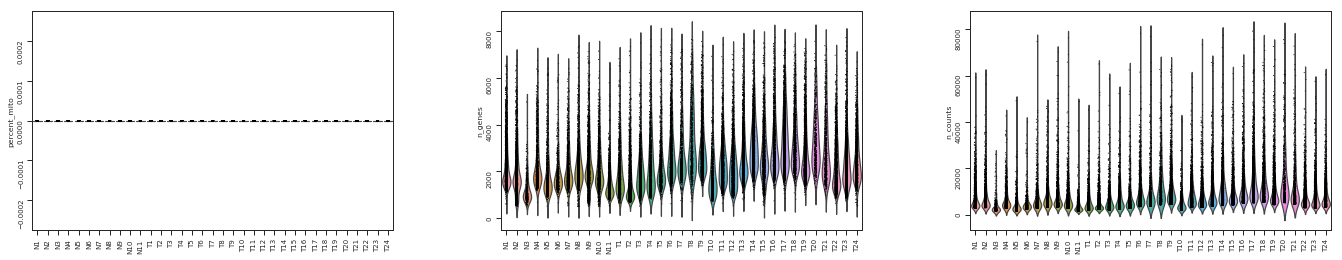

In [41]:
### check mitochondrial reads per sample 
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.after_filtering.split.png')

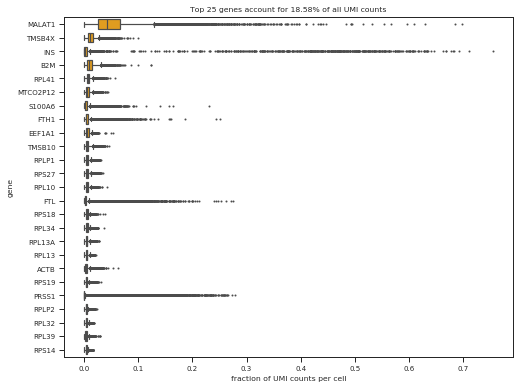

In [42]:
#display the top 25 genes in the dataset
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (8, 6))
bc.pl.top_genes_counts(adata=adata, top_n=25, ax = ax )
fig.savefig(os.path.join(results_folder, 'figures/top_genes.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

### Per-cell normalization, and output of normalized results ###

In [43]:
adata = bc.st.per_cell_normalize(adata, results_folder)

adata normalized per cell


LOG MESSAGE: Per cell normalization completed successfully.
LOG MESSAGE: Per cell normalization completed successfully.
LOG MESSAGE: 	Time for per-cell normalization: 6.32s
LOG MESSAGE: 	Time for per-cell normalization: 6.32s


log1p values saved into adata.raw
writing out matrix.mtx ...
adata.X successfully written to matrix.mtx
genes successfully written out to genes.tsv
cellbarcodes successfully written out to barcodes.tsv


LOG MESSAGE: cp10k values exported to file.
LOG MESSAGE: cp10k values exported to file.
LOG MESSAGE: 	Time for cp10k export: 389.143s
LOG MESSAGE: 	Time for cp10k export: 389.143s


annotation successfully written out to metadata.tsv


### Feature selection (highly variable genes) for clustering ###

log1p taken of adata


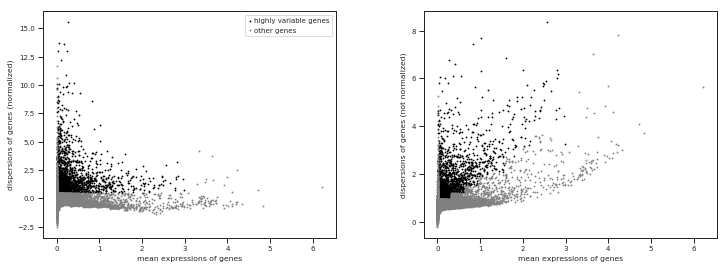

LOG MESSAGE: After feature selection of highly variable genes: 57423 cells, 2033 genes
LOG MESSAGE: After feature selection of highly variable genes: 57423 cells, 2033 genes
LOG MESSAGE: 	Time for feature selection: 22.822s
LOG MESSAGE: 	Time for feature selection: 22.822s


In [44]:
adata = bc.st.highly_variable_genes(adata)

### Regression steps, and output of regressed data ###

In [45]:
adata 

View of AnnData object with n_obs × n_vars = 57423 × 2033 
    obs: 'CELL', 'CONDITION', 'Patient', 'Type', 'Cell_type', 'percent_mito', 'n_counts', 'n_genes'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'total_counts', 'frac_reads'

In [46]:
# RMK : AS OF FEB 2020 there is a bug in scanpy regress out if scanpy installed with PIP (see https://github.com/theislab/scanpy/issues/707)
# Before the fix is available, one should coopy the data toprevet it. hence the adata = adata.copy()
adata = adata.copy()
adata = bc.st.regress_out(adata, results_folder)

'n_counts' and 'percent_mito' regressed out


LOG MESSAGE: Regression steps completed. 'n_counts' and 'percent_mito' regressed out. adata was log-normalized and scaled.
LOG MESSAGE: Regression steps completed. 'n_counts' and 'percent_mito' regressed out. adata was log-normalized and scaled.
LOG MESSAGE: 	Time for regression steps: 91.742s
LOG MESSAGE: 	Time for regression steps: 91.742s


adata scaled with max_value set to 10


### Batch correction and PCA neighbor analysis and UMAP

The standard workflow uses bbknn as  batch correction method.


Using random_state = 0 for all the following calculations
PCA calculated using svd_solver = 'arpack'. PCA multiplied by -1 to match Seurat output.


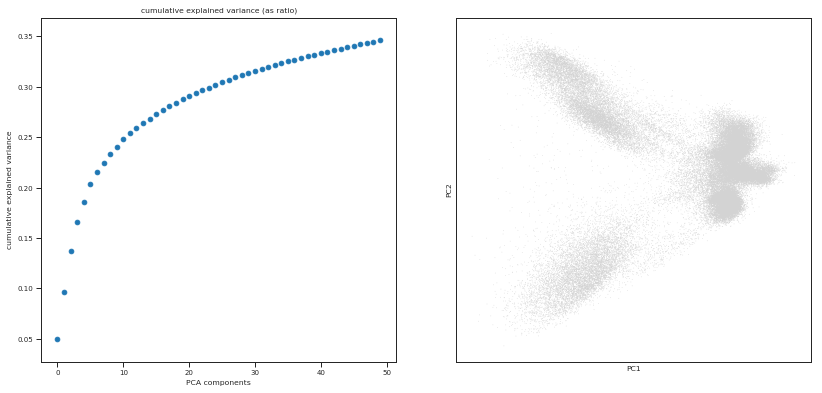

Nearest neighbors calculated with n_neighbors = 10


LOG MESSAGE: Neighborhood analysis completed, and UMAP generated.
LOG MESSAGE: Neighborhood analysis completed, and UMAP generated.
LOG MESSAGE: 	 Time for PCA, nearest neighbor calculation and UMAP generation: 110.329s
LOG MESSAGE: 	 Time for PCA, nearest neighbor calculation and UMAP generation: 110.329s


UMAP coordinates calculated.


LOG MESSAGE: Metadata containing 3 PCAs and UMAP coordinates exported successfully to file.
LOG MESSAGE: Metadata containing 3 PCAs and UMAP coordinates exported successfully to file.
LOG MESSAGE: Time for export: 0.505s
LOG MESSAGE: Time for export: 0.505s


results successfully written out to 'analysis_metadata.tsv'


In [47]:
if (batch_to_correct != 'None'):
    #save a copy of uncorrected in case we need it for something later
    adata_uncorrected = adata.copy()
    adata.obs['batch'] = adata.obs[batch_to_correct]
    adata = bc.st.pca_neighbors_umap(adata,results_folder, method='bbknn')
else:
    adata = bc.st.pca_neighbors_umap(adata, results_folder)
    

### Clustering ###

leiden clustering performed with a resolution of 1.5


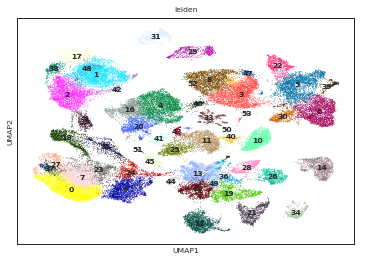

LOG MESSAGE: leidenclustering done. Found 54 clusters.
LOG MESSAGE: leidenclustering done. Found 54 clusters.
LOG MESSAGE: 	Time for leiden clustering: 18.24s
LOG MESSAGE: 	Time for leiden clustering: 18.24s
LOG MESSAGE: Marker gene detection performed on a per-cluster basis using the method wilcoxon.
LOG MESSAGE: Marker gene detection performed on a per-cluster basis using the method wilcoxon.
LOG MESSAGE: 	Time for marker gene detection: 461.602s
LOG MESSAGE: 	Time for marker gene detection: 461.602s


rank genes per cluster calculated using method wilcoxon.
mapping of cells to  leiden exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out
./analyzed/StdWf1_PRJCA001063_CRC_besca2/labelings/leiden/WilxRank.gct written out
./analyzed/StdWf1_PRJCA001063_CRC_besca2/labelings/leiden/WilxRank.pvalues.gct written out


LOG MESSAGE: Cluster level analysis and marker genes exported to file.
LOG MESSAGE: Cluster level analysis and marker genes exported to file.
LOG MESSAGE: 	Time for export of cluster level analysis: 22.121s
LOG MESSAGE: 	Time for export of cluster level analysis: 22.121s


./analyzed/StdWf1_PRJCA001063_CRC_besca2/labelings/leiden/WilxRank.logFC.gct written out


In [48]:
# leiden clustering is the default 
adata = bc.st.clustering(adata, results_folder, myres=1.5) ## at this resolution, B cells are split Naive + Memory

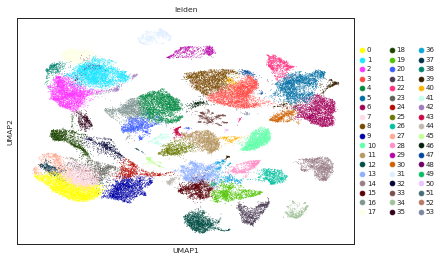

In [49]:
sc.pl.umap(adata,color=['leiden'])

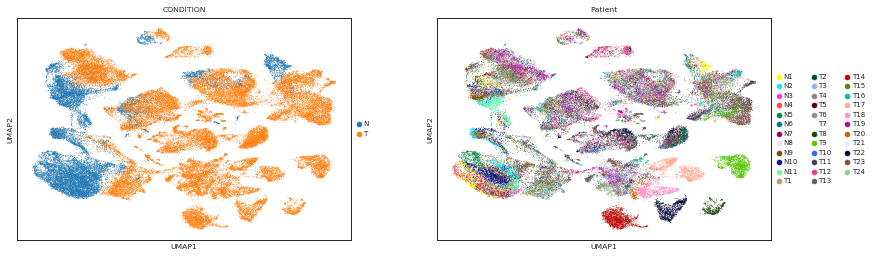

In [50]:
sc.pl.umap(adata,color=['CONDITION','Patient'])

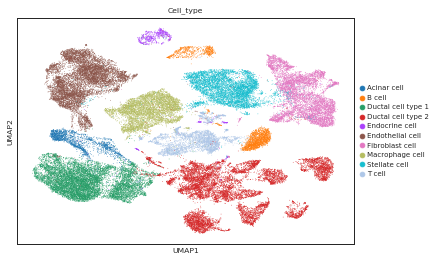

In [51]:
sc.pl.umap(adata,color=['Cell_type'])

In [52]:
# everything that was done so far goes to the .h5ad file for later use
adata.write(results_file)
#print(results_file)

### Additional Labeling ###

(if specified) based on external annotation in "metadata.tsv"  the additional labeling will be exported to file and the fract_pos.gct and average.gct files generated

In [53]:
if (labeling_to_use != 'None'):
    adata = bc.st.additional_labeling(adata, labeling_to_use, labeling_name, labeling_description, labeling_author, results_folder)

LOG MESSAGE: Marker gene detection performed on a per-label basis using the method wilcoxon.
LOG MESSAGE: Marker gene detection performed on a per-label basis using the method wilcoxon.
LOG MESSAGE: 	Time for marker gene detection: 147.952s
LOG MESSAGE: 	Time for marker gene detection: 147.952s


rank genes per label calculated using method wilcoxon.
mapping of cells to  Cell_type exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out
./analyzed/StdWf1_PRJCA001063_CRC_besca2/labelings/Cell_type/WilxRank.gct written out
./analyzed/StdWf1_PRJCA001063_CRC_besca2/labelings/Cell_type/WilxRank.pvalues.gct written out


LOG MESSAGE: Label level analysis and marker genes exported to file.
LOG MESSAGE: Label level analysis and marker genes exported to file.
LOG MESSAGE: 	Time for export of cluster level analysis: 11.887s
LOG MESSAGE: 	Time for export of cluster level analysis: 11.887s


./analyzed/StdWf1_PRJCA001063_CRC_besca2/labelings/Cell_type/WilxRank.logFC.gct written out


### Complete log-file

In [54]:
logging.info('Entire workflow completed.')
logging.info('\tTime for entire workflow: '+str(round(time.time()-start0, 3))+'s')

LOG MESSAGE: Entire workflow completed.
LOG MESSAGE: Entire workflow completed.
LOG MESSAGE: 	Time for entire workflow: 1853.888s
LOG MESSAGE: 	Time for entire workflow: 1853.888s


### Write QC Report

In [55]:
bc.st.write_qc(adata_unfiltered = adata_unfiltered, 
                 adata_filtered = adata,
                 version = version, 
                 analysis_name = analysis_name, 
                 standard_min_genes = standard_min_genes, 
                 standard_min_cells = standard_min_cells, 
                 standard_min_counts = standard_min_counts, 
                 standard_percent_mito = standard_percent_mito, 
                 standard_max_counts = standard_max_counts,
                 standard_n_genes = standard_n_genes,
                 filtering_output1 = filtering1,
                 filtering_output2 = filtering2,
                 results_folder = results_folder,
                 css_path = os.path.join(os.path.dirname(bc.__file__),'st', 'style.css'))
logging.info('QC Report generated and saved as .html')

LOG MESSAGE: QC Report generated and saved as .html
LOG MESSAGE: QC Report generated and saved as .html


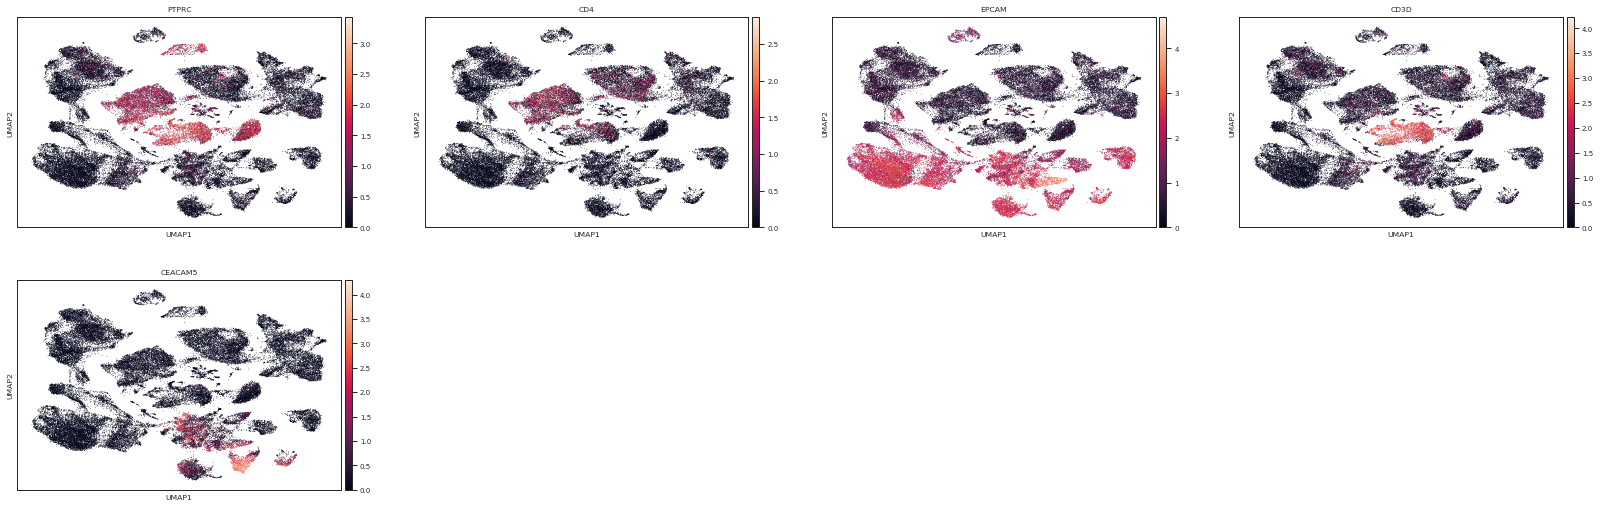

In [57]:
sc.pl.umap(adata,color=['PTPRC','CD4','EPCAM','CD3D', 'CEACAM5'])